In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [5]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CSV
        self.df = pd.read_csv("data\case\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]

        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        
        self.data = np.asarray(self.df,dtype=np.float32)
        self.norm = np.linalg.norm(self.data)
        self.data = self.data / self.norm
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        # idx = 0
        return self.data[idx:idx+self.numFeat],self.data[idx+1:idx+self.numFeat+self.numOut]

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (798451274.py, line 5)

In [ ]:
#create data loaders
numFeat = 10
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=100,drop_last=False,shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\case\\FluViewPhase2Data\\WHO_NREVSS_Combined_prior_to_2015_16.csv'

In [ ]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 1
sequenceLength = numFeat
numLayers = 1
hiddenSize = 64
batchSize = 100

class LSTM(nn.Module):
    def __init__(self,inputSize,hiddenSize,numLayers,numOut,sequenceLength,future=0):
        super(LSTM, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.numOut = numOut
        self.future = future
        # print(batchSize,sequenceLength,inputSize)
        # self.LSTM = nn.LSTM(inputSize,hiddenSize,numLayers,batch_first=True)
        self.lstm = nn.LSTMCell(1,hiddenSize)
        # self.lstm2 = nn.LSTMCell(hiddenSize,hiddenSize,bias=False)
        self.fc = nn.Linear(hiddenSize,self.numOut)
        
    def forward(self,x):
        outputs = []
        nSamples = x.size(0)
        h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        c_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        
        for input in x.split(1,dim=1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        return outputs

    def predict(self,x,future):
        outputs = []
        nSamples = x.size(0)
        h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        c_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        
        for input in x.split(1,dim=1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        for i in range(future-1):
            h_1, _ = self.lstm(out, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        return outputs[-future+1::]

model = LSTM(inputSize,hiddenSize,numLayers,numOut,sequenceLength)

In [ ]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.size())
        # X = X[:,:,None]
        pred = model(X)
        # print(pred.size())
        # print(y.size())
        # print("pred",pred.size())
        # print("Y",y.size())
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
learning_rate = .005
batch_size = 100
epochs = 100
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print(list(model.parameters()))

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 0.005984  [    0/  782]
loss(1): 0.000674  [    0/  782]
loss(2): 0.000687  [    0/  782]
loss(3): 0.000566  [    0/  782]
loss(4): 0.000404  [    0/  782]
loss(5): 0.000499  [    0/  782]
loss(6): 0.000892  [    0/  782]
loss(7): 0.000268  [    0/  782]
loss(8): 0.000586  [    0/  782]
loss(9): 0.000316  [    0/  782]
loss(10): 0.000369  [    0/  782]
loss(11): 0.000259  [    0/  782]
loss(12): 0.000216  [    0/  782]
loss(13): 0.000283  [    0/  782]
loss(14): 0.000097  [    0/  782]
loss(15): 0.000167  [    0/  782]
loss(16): 0.000093  [    0/  782]
loss(17): 0.000126  [    0/  782]
loss(18): 0.000089  [    0/  782]
loss(19): 0.000105  [    0/  782]
loss(20): 0.000047  [    0/  782]
loss(21): 0.000086  [    0/  782]
loss(22): 0.000111  [    0/  782]
loss(23): 0.000096  [    0/  782]
loss(24): 0.000074  [    0/  782]
loss(25): 0.000097  [    0/  782]
loss(26): 0.000036  [    0/  782]
loss(27): 0.000106  [    0/  782]
loss(28): 0.000075  [    0/  782]
loss(29): 0.000086  [   

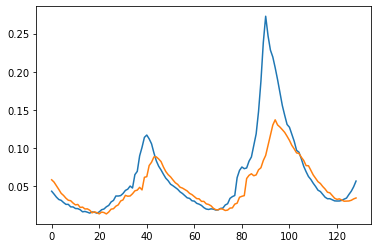

In [ ]:
def test_loop(model):
    numFeat = 10
    numOut = 4
    test_data = dataSetAll(2013,2100,numFeat,numOut)

    with torch.no_grad():
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            Y = test_data[idx][1]
            feat = X[None,:]
            pred = model.predict(feat,numOut)[0]
            plt.plot(Y)
            print(pred)
            plt.plot(pred)
            
            plt.show()
            # break


def graph(model):
    numFeat = 10
    numOut = 4
    test_data = dataSetAll(2013,2100,numFeat,numOut)

    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            y = test_data[idx][1]
            feat = X[None,:]

            pred = model.predict(feat,numOut)[0]
            future = 3

            predY.append(pred[numFeat-1::][future])
            actY.append(y[numFeat-1::][future])   
            
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

graph(model)
# test_loop(model)
